# Notebook: Approche non-supervisée

## Mise en place

Librairies et paramétrages utilisés tout au long du notebook

In [1]:
import time
import pickle
import warnings
import numpy as np
import pandas as pd

import re
import spacy
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phraser
from gensim.models.wrappers import LdaMallet
from gensim.models import Phrases, CoherenceModel

import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=ResourceWarning)
warnings.filterwarnings("ignore",category=RuntimeWarning)
warnings.filterwarnings("ignore",category=ImportWarning)

Téléchargement des questions posées sur StackOverflow depuis [StackExchange](https://data.stackexchange.com/stackoverflow/query/new) avec les commandes SQL suivantes (pour  $n \in \{0, 1, 2, 3\}$)

```SQL
SELECT Id, Body, Title, Tags
FROM Posts
WHERE Score >= 3 AND PostTypeId = 1
ORDER BY RAND() OFFSET n*50000 ROWS;
```

In [3]:
n_files = 4
list_files = [pd.read_csv(f'data/QueryResults-{n+1}.csv', index_col='Id') 
              for n in range(n_files)]

data = pd.concat(list_files, axis=0).drop_duplicates()
data.head()

,Body,Title,Tags
Id,,,
1771099,<p>One of the features of my project is to all...,Choosing a Path for Python File Access,<python><path>
1771101,<p>Is there any open source software to map po...,Open source motion-capture software,<simulation><tracking><3d-modelling>
1771102,"<p>As the title says, how does one change the ...",Changing Emacs Forward-Word Behaviour,<emacs><emacs23>
1771104,"<p>When loading all unit tests in a package, t...",JUnit java.lang.OutOfMemoryError when running ...,<java><unit-testing><junit><out-of-memory>
1771117,"<p>For a specific example, consider <code>atoi...",Why doesn't C++ reimplement C standard functio...,<c++><c><stl>


## Pré-traitement

Pour le reste du traitement, concaténons les chaines de `Title` et `Body` dans le même document pour chaque question. Aussi choississons au hasard 4 questions dont nous suivrons l'évolution au fur et à mesure des transformations au cours de la phase de pré-traitement.

In [4]:
sample = np.random.choice(len(data), 4)

def random_display(docs, sample):
    for s in sample:
        print(docs.iloc[s], '\n'+'-'*20+'\n'*2)

In [5]:
texts = data.Title + ' ' +data.Body

random_display(texts, sample)

How do I position two divs vertically where the top one takes the remaining height? <p>The markup is like:-</p>

<pre><code>&lt;div id="parent"&gt;
    &lt;div class="top"&gt;
        &lt;ul&gt;
            &lt;li&gt;...
        &lt;/ul&gt;
    &lt;/div&gt;
    &lt;div class="bottom"&gt;
        &lt;ul&gt;
            &lt;li&gt;Option A
            &lt;li&gt;Option B
            &lt;li&gt;Option C
        &lt;/ul&gt;
    &lt;/div&gt;
&lt;/div&gt;
</code></pre>

<p>And the CSS is:-</p>

<pre><code>div {
    border: 1px solid black;
}

#parent {
    position: fixed;
    top: 0;
    left: 0;
    height: 100%;
    width: 100%;
    overflow: hidden;
}

.top {
    max-height: 200px;
    overflow: scroll;
}
</code></pre>

<p>So, basically what I want is that <code>bottom</code> <code>div</code> should touch the lower edge of the window and the rest space should be taken by <code>top</code> <code>div</code>. My current approach of setting <code>max-height</code> in <code>top</code> <code>div</

La première partie de notre travail consiste à *nettoyer* le texte, à savoir

1. Supprimer les parties superflues: les parties de codes, les tags HTML, les ponctuations…
2. Créer des `tokens`: à savoir séparer pour chaque document leur texte en une liste de mots 
3. Retirer les `stopwords`: les mots considérés comme étant trop courant pour être intéressants dans notre analyse
4. Lemmatiser: transformer tous les mots dans une forme basique quelque soit la forme dans laquelle il apparait dans le document (pluriel, verbe conjugué, forme féminine…)
5. `POS tagging and filtering`: assigner à chaque mot une étiquette en fonction de leur nature grammaticale et de la place qu'ils occupent dans une phrase. En fonction de ces étiquettes, supprimer les mots n'ayant pas un rôle grammatical jugé intéressant pour notre analyse.

Appliquons les deux premières étapes dans un premier temps

In [6]:
texts_cleaned = (texts
                 .apply(lambda x: re.sub('<code>(.|\n)*?</code>', '', x)) # delete code parts
                 .apply(lambda x: re.sub('<[^<]+?>', '', x)) # remove HTML tags
                 .apply(lambda x: simple_preprocess(x, min_len=1, deacc=False))
                )

random_display(texts_cleaned, sample)

['how', 'do', 'i', 'position', 'two', 'divs', 'vertically', 'where', 'the', 'top', 'one', 'takes', 'the', 'remaining', 'height', 'the', 'markup', 'is', 'like', 'and', 'the', 'css', 'is', 'so', 'basically', 'what', 'i', 'want', 'is', 'that', 'should', 'touch', 'the', 'lower', 'edge', 'of', 'the', 'window', 'and', 'the', 'rest', 'space', 'should', 'be', 'taken', 'by', 'my', 'current', 'approach', 'of', 'setting', 'in', 'is', 'clearly', 'not', 'good', 'since', 'based', 'on', 'screen', 'size', 'on', 'mobiles', 'it', 'will', 'be', 'either', 'too', 'less', 'or', 'big', 'can', 'i', 'achieve', 'this', 'using', 'css', 'only', 'here', 'is', 'a', 'jsfiddle', 'for', 'this', 'http', 'jsfiddle', 'net', 'ldr', 'h', 'r'] 
--------------------


['rails', 'restful', 'resources', 'using', 'to_param', 'for', 'a', 'field', 'that', 'contains', 'separator', 'characters', 'i', 'want', 'my', 'rails', 'app', 'to', 'respond', 'to', 'and', 'generate', 'urls', 'like', 'so', 'in', 'my', 'config', 'routes', 'rb', '

Nous pouvons observer que documents sont devenus des listes de mots. Cependant beaucoup ne seront pas pertinents (tels que les opérateurs `do`, `be`…). Pour changer cela, appliquons les 3 dernières étapes de notre nettoyage de texte.

In [7]:
# Remove stopwords
stop_words = stopwords.words('english')
# stop_words.extend([])
def remove_stopwords(doc):
    return [word for word in doc if word not in stop_words] 


# Add bigrams
bigrammer = Phraser(Phrases(texts_cleaned, threshold=10)) 
def make_bigrams(doc, bigrammer):
    return bigrammer[doc]


# Lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatization(doc, nlp, banned_postags=['PUNCT', 'DET', 'PRON', 'CONJ', 'ADV', 'INTJ']):
    doc = nlp(" ".join(doc))
    return [token.lemma_ for token in doc if token.pos_ not in banned_postags]


# All processing
texts_lemmas = (texts_cleaned
                .apply(remove_stopwords)
                .apply(lemmatization, nlp=nlp)
                .apply(make_bigrams, bigrammer=bigrammer)
               )

random_display(texts_lemmas, sample)

['position', 'two', 'div', 'top', 'one', 'take', 'remain', 'height', 'markup', 'like', 'css', 'want', 'touch', 'low', 'edge', 'window', 'rest', 'space', 'take', 'current', 'approach', 'set', 'good', 'since', 'base', 'screen', 'size', 'mobile', 'either', 'big', 'achieve', 'use', 'css', 'jsfiddle', 'http_jsfiddle', 'net', 'ldr', 'h', 'r'] 
--------------------


['rail', 'restful', 'resource', 'use', 'to_param', 'field', 'contain', 'separator', 'character', 'want', 'rail', 'app', 'respond', 'generate', 'url', 'like', 'config', 'route', 'rb', 'access', 'resource', 'modify', 'website', 'model', 'generate', 'good', 'url', 'like', 'domain', 'name', 'contain', 'character', 'rail', 'get', 'unhappy', 'believe', 'character', 'define', 'rout', 'separator', 'list', 'special_character', 'split', 'url', 'allow', 'stuff', 'like', 'website', 'xml', 'clean', 'way', 'allow', 'character', 'restful', 'url', 'try', 'redefine', 'rout', 'separator', 'include', 'bad', 'way', 'solve', 'problem', 'mess', 'gener

Dans nos exemples retenus, nous observons un bien moins grand nombre de mots restants, comparé aux documents bruts.

Il est maintenant temps de *normaliser* notre texte, à savoir le mettre dans un format dans lequel notre modèle sera capable de le comprendre. Pour ce faire, nous allons dans un premier temps créer un dictionnaire qui assignera un identifiant unique à chaque mots présents dans l'ensemble des documents. Nous affichons aussi le nombre de mots présents dans ce dictionnaire

In [8]:
dictionary = Dictionary(texts_lemmas)
print("Taille du dictionnaire: ",len(dictionary))

Taille du dictionnaire:  136823


Afin de s'assurer que ces mots peuvent nous aider un minimum à trouver des *patterns* intéressants dans nos données au moment de la modélisation, nous supprimons du dictionnaire les mots qui n'apparaissent pas dans au moins 5 documents différents.

In [9]:
dictionary.filter_extremes(no_below=5)
print("Taille du dictionnaire: ", len(dictionary))

Taille du dictionnaire:  28380


Avec ce filtrage, nous avons enlever plus de 80% des mots du dictionnaire, qui auraient pu être source de bruit une fois devenus descripteurs. Aussi, afin de ne pas avoir des mots trop communs (comme les stopwords), observons les items les plus communs

In [10]:
words_sorted = sorted(dictionary.dfs.items(), key=lambda x: x[1], reverse=True)
id2token = {value: key for key, value in dictionary.token2id.items()}

print("Mots les plus fréquents du dictionnaire:")
for e, (i, count) in enumerate(words_sorted[:50]):
    print(f"{e+1:2} {id2token[i]:15} {count:5}")

Mots les plus fréquents du dictionnaire:
 1 get             64892
 2 work            56557
 3 try             55240
 4 code            54350
 5 like            52839
 6 want            50983
 7 way             48988
 8 would           48118
 9 one             39443
10 need            37073
11 find            34366
12 follow          34179
13 file            33876
14 thank           33762
15 know            32337
16 problem         32216
17 create          31700
18 make            30017
19 example         29959
20 look            29015
21 run             28662
22 error           26590
23 see             26588
24 seem            25920
25 question        25290
26 call            24797
27 add             24702
28 set             24448
29 good            24254
30 time            23527
31 application     23121
32 method          23036
33 could           23008
34 help            22466
35 change          22389
36 value           22068
37 function        21886
38 datum           21494
39 user  

Nous décidons de supprimer certains des mots les plus fréquents jugés inutiles.

In [11]:
to_delete = ['code', 'create', 'could', 'example', 'follow', 'get', 'good', 'know', 'like', 'need', 'one', 
             'question', 'see', 'seem', 'thank', 'try', 'want', 'way', 'work', 'would']

bad_ids = [dictionary.token2id[token] for token in to_delete]

dictionary.filter_tokens(bad_ids=bad_ids)

Et enfin, pour conclure notre partie de pré-traitement, nous créeons nos `bag of words`. Cette représentation permet de compter le nombre d'occurence de chaque mot du dictionnaire pour chaque document. La dataframe résultante nous servira de données d'entrée à notre modèle.

In [12]:
corpus = texts_lemmas.apply(dictionary.doc2bow)
random_display(corpus, sample)

[(66, 1), (76, 1), (121, 1), (140, 1), (197, 1), (202, 1), (240, 1), (266, 1), (273, 1), (292, 1), (301, 1), (303, 1), (304, 2), (401, 1), (405, 1), (413, 2), (559, 1), (583, 1), (1001, 1), (1020, 1), (1235, 1), (1240, 1), (1285, 1), (1715, 1), (1928, 1), (2042, 1), (2538, 1), (2541, 1), (3115, 1), (3116, 1), (3458, 1)] 
--------------------


[(1, 1), (4, 1), (7, 2), (13, 1), (22, 1), (42, 1), (52, 3), (71, 4), (88, 1), (113, 1), (114, 1), (123, 1), (130, 1), (166, 1), (182, 2), (234, 2), (240, 1), (258, 1), (262, 1), (283, 1), (309, 1), (319, 1), (464, 2), (487, 1), (496, 3), (541, 6), (608, 1), (665, 2), (738, 4), (812, 2), (815, 2), (905, 1), (1096, 1), (1098, 3), (1265, 1), (1574, 1), (1669, 1), (1750, 1), (1841, 1), (2153, 2), (2162, 1), (2289, 1), (2523, 3), (2656, 2), (3047, 1), (3804, 1), (4070, 1), (5376, 1), (7120, 1), (8195, 1), (8565, 2)] 
--------------------


[(3, 3), (28, 6), (70, 1), (248, 3), (249, 2), (250, 1), (268, 1), (299, 4), (467, 1), (578, 1), (913, 1), (966,

## Phase de modélisation

Afin de pouvoir catégoriser de manière non-supervisée les questions de notre corpus, nous utilisons l'implémentation du *Latent Dirichlet Allocation* (LDA) de Mallet. Nous entrainons plusieurs modèles avec une valeur préindiquée de nombre de sujets autour desquels grouper les documents, et cherchons le meilleur en fonction de la valeur de cohérence.

```python
# Initialization
mallet_path = "mallet-2.0.8/bin/mallet"
start, limit, step = 4, 21, 2
coherence_values = []
model_list = []


# Processing
for num_topics in range(start, limit, step):
    start = time.time()
    
    model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, alpha=round(50/num_topics), id2word=dictionary, workers=8)
    model_list.append(model)
    coherencevalue = CoherenceModel(model=model, texts=texts_lemmas, dictionary=dictionary).get_coherence()
    coherence_values.append(coherencevalue)
        
    # display training information along the way
    minutes, seconds = divmod(time.time()-start, 60)
        
    str_perf = f"Nombre de topics: {num_topics:2} ... Valeur de coherence: {coherencevalue:.3} ... "
    str_time = f"Temps d'entrainement et d'évaluation: {round(minutes):2} minutes {round(seconds):2} secondes..."
    print(str_perf + str_time)
```

In [28]:
from gensim.models import LdaMulticore
lda_model = LdaMulticore(corpus, id2word=dictionary, alpha='asymmetric', num_topics=18, workers=3)

In [31]:
with open('model_unsupervised.pkl', 'wb') as f:
    pickle.dump(lda_model, f)
    
with open('dico_unsupervised.pkl', 'wb') as f:
    pickle.dump(dictionary, f)

Représentons graphiquement l'évolution de la cohérence

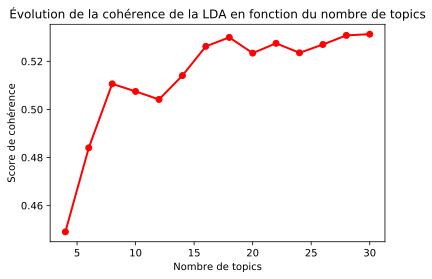

In [41]:
n_topics = range(4, limit, step)
plt.plot(n_topics, coherence_values, 'r-', linewidth='2')
plt.plot(n_topics, coherence_values, 'ro', linewidth='5')
plt.xlabel("Nombre de topics")
plt.ylabel("Score de cohérence")
plt.title("Évolution de la cohérence de la LDA en fonction du nombre de topics");

## Interprétation des résultats

Nous choisissons de garder le modèle à 18 topics comme modèle final. En effet, d'après notre courbe d'évolution, on remarque que la valeur de cohérence atteint un plateau à partir de cette valeur, et ne dévie que très légèrement pour le nombre de topics suivants.

In [42]:
optimal_model = model_list[7]

with open('model_unsupervised.pkl', 'wb') as f:
    pickle.dump(optimal_model, f)

Pour chaque topic dégagé, affichons la liste des mots les plus probables.

In [152]:
for i in range(optimal_model.num_topics):
    desc = optimal_model.show_topic(i, topn=10)
    words = ', '.join([word for word, prob in desc])
    print(f'Topic #{i+1:2}:\n\t', words)

Topic # 1:
	 list, array, element, date, key, time, item, return, object, loop
Topic # 2:
	 page, html, javascript, jquery, browser, link, tag, php, css, element
Topic # 3:
	 image, view, set, color, change, size, make, text, display, screen
Topic # 4:
	 run, test, python, error, script, command, file, php, output, log
Topic # 5:
	 table, database, query, datum, column, row, sql, store, record, mysql
Topic # 6:
	 class, method, object, call, property, type, exception, instance, interface, implement
Topic # 7:
	 user, event, button, control, select, click, form, change, show, item
Topic # 8:
	 window, application, net, error, run, system, visual_studio, project, dll, debug
Topic # 9:
	 app, android, device, application, ios, iphone, activity, video, xcode, find
Topic #10:
	 time, thread, process, run, memory, call, read, datum, write, cache
Topic #11:
	 write, thing, make, application, language, find, project, learn, lot, library
Topic #12:
	 function, type, variable, call, error, retur

Pour chacun des documents, trouvons le topic qui contribue le plus à sa distribution de mots

In [44]:
dominant_topics = []
perc_contributions = []

for predictions in optimal_model[corpus]:
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    topic_num, topic_contrib = predictions[0] # Get most contributing topic
    dominant_topics.append(int(topic_num+1))
    perc_contributions.append(round(topic_contrib, 4))
    
docs_dominants = pd.DataFrame({'Dominant Topic': dominant_topics, 'Contribution': perc_contributions, 'Index': texts.index})
docs_dominants.set_index(['Index'], inplace=True)
docs_dominants.head()

,Contribution,Dominant Topic
Index,,
1771099,0.3781,13
1771101,0.4295,11
1771102,0.3900,7
1771104,0.3826,4
1771117,0.5856,11


Avec cette nouvelle frame, tentons de segmenter notre jeu de données en calculant:
- le nombre de documents par top topic contributeur
- la proportion de documents par top topic contributeur

In [46]:
# Number of documents for each topic
docs_per_topic = (docs_dominants['Dominant Topic']
                  .value_counts(sort=False)
                  .to_frame()
                  .rename(columns={'Dominant Topic': 'Document count'})
                 )

# Proportion of documents for each topic
topic_props = (docs_per_topic.divide(docs_per_topic.sum())
               .round(4)
               .rename(columns={'Document count': 'Document proportion'})
              )

Attachons ces informations avec les mots-clés descripteurs des topics

In [47]:
# Most probable keywords per topic
keywords = []
for i in range(optimal_model.num_topics):
    desc = optimal_model.show_topic(i)
    keywords.append(', '.join([word for word, prob in desc]))

num_topics = [i+1 for i in range(optimal_model.num_topics)]
df_topics_keywords = pd.DataFrame({'Topic #': num_topics, 'Keywords': keywords})
df_topics_keywords.set_index(['Topic #'], inplace=True)

# Final Frame
df_dominant_topics = df_topics_keywords.join([docs_per_topic, topic_props])
df_dominant_topics.sort_values(['Document proportion'], ascending=False, inplace=True)
df_dominant_topics

,Keywords,Document count,Document proportion
Topic #,,,
12,"function, type, variable, call, error, return,...",14504,0.0725
5,"table, database, query, datum, column, row, sq...",14387,0.0719
15,"string, file, line, text, character, format, c...",13068,0.0653
18,"server, user, client, request, send, service, ...",12902,0.0645
6,"class, method, object, call, property, type, e...",12758,0.0638
3,"image, view, set, color, change, size, make, t...",12706,0.0635
11,"write, thing, make, application, language, fin...",11510,0.0576
4,"run, test, python, error, script, command, fil...",11069,0.0553
7,"user, event, button, control, select, click, f...",11052,0.0553


De manière plus détaillée, nous prendrons ici plusieurs examples auxquels nous suggérerons des tags. Pour ce faire, nous chercherons parmi les mots-clés caractéristiques du topic dominant du dit exemple ceux qui y figurent. Ces exemples que nous sélectionnons sont considérés comme les plus représentatifs de chaque domaine.

In [161]:
top_categories = (docs_dominants.sort_values(['Contribution'],ascending=False)
                  .groupby(['Dominant Topic'], sort=False)
                  .head(1)
                  .sort_values(['Dominant Topic'])
                  .reset_index().set_index(['Dominant Topic'])
                 )

examples = (top_categories
            .join(corpus.apply(len).to_frame('Length'), 'Index')
            .sort_values('Length', ascending=False).Index)

def show_example(corpus, lemmas, data, examples, model, n_ex):
    predictions = model[corpus[examples.iloc[n_ex]]]
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    
    topic_num, topic_contrib = predictions[0]
    desc = optimal_model.show_topic(topic_num, topn=20)
    
    keywords = [word for word, prob in desc]
    tags = {lemma for lemma in lemmas[examples.iloc[n_ex]] if lemma in keywords}

    display(HTML(data.loc[examples.iloc[n_ex], 'Body']))
    print("-"*30, '\nTags proposés: ')
    print(tags)

In [162]:
show_example(corpus, texts_lemmas, data, examples, optimal_model, 5)

------------------------------ 
Tags proposés: 
{'problem', 'block', 'write', 'wait', 'process', 'thread', 'run', 'program'}


In [163]:
show_example(corpus, texts_lemmas, data, examples, optimal_model, 7)

------------------------------ 
Tags proposés: 
{'request', 'client', 'server', 'connect', 'message', 'send', 'connection', 'access', 'http'}


In [164]:
show_example(corpus, texts_lemmas, data, examples, optimal_model, 9)

------------------------------ 
Tags proposés: 
{'mysql', 'table', 'database', 'row', 'insert'}
